I recently heard about the [Reaktoro](https://bitbucket.org/reaktoro/reaktoro) project, which is a platform for the fast calculation of geochemical reactions (both equilibrium and kinetics). I'm working mostly with the adsorption reactions, so I was not interested at the beginning although the code is very polished, clean, and readable even for me with a tiny knowledge of C++. At the end the Python interface and the [Helgeson-Kirkham-Flowers](http://www.ajsonline.org/content/281/10/1249.short) (HKF) equation of state tempted me to give it a try. I followed the installation procedure [here](http://reaktoro.org/installation.html) and it went very well on my Linux Mint machine. The Python package is installed in the `/usr/local/lib/python2.7/site-packages/` which is not in the python path. You need to add it manually:

In [1]:
import sys
sys.path.append("/usr/local/lib/python2.7/site-packages/")

Then I looked at the Python examples and demos and found the answer to my question: calculation of (partial molar) Gibbs energy and the equilibrium constants for some electrolyte reactions, using the HKF EOS and a beautiful scripting language. It even convinced me to create a bitbucket account! As an example, the following code (that is a modified version of a Reaktoro example) is how the equilibrium constant for a reaction can be calculated:

In [2]:
from reaktoro import *
from numpy import *
import matplotlib.pyplot as plt

In [3]:
database = Database("supcrt98.xml")
thermo = Thermo(database)

I am interested in the equilibrium constant of the following reaction:  
$$ CaOH^+ + SO_4^{-2} = CaSO_4 + OH^-$$
I tried different way of writing this reaction and finally the following version worked:

In [4]:
reac1 = 'CaOH+ + SO4-- = CaSO4(aq) + OH-'
T = 300 # K
p = 1e5 # Pa
R = 8.3144598 # J/(mol.K)
thermo.lnEquilibriumConstant(T, p, reac1).val

2.145092126874757

Let's do the calculation by using the basic relation 
$$\ln K_{eq} = \frac{-\Delta_r G}{RT} $$ 

In [5]:
dgrt = thermo.standardPartialMolarGibbsEnergy(T, p, 'CaSO4(aq)').val+ \
thermo.standardPartialMolarGibbsEnergy(T, p, 'OH-').val- \
thermo.standardPartialMolarGibbsEnergy(T, p, 'SO4--').val- \
thermo.standardPartialMolarGibbsEnergy(T, p, 'CaOH+').val
-dgrt/R/T

2.1450927202641066

There is a small difference between the two values that I guess is due to the difference between the number of significant digits that I have used for the universal gas constant. Otherwise, everything works great, and the values are in agreement with what I have previously calculated myself.

## Van't Hoff equation
Let's do something interesting. We know from [Van't Hoff](https://en.wikipedia.org/wiki/Van_%27t_Hoff_equation) equation that
$$\frac{\text{d}\ln K_{eq}}{\text{d}\frac{1}{T}} = -\frac{\Delta_r H}{R}.$$
It means that if I plot $\ln K_{eq}$ versus $\frac{1}{T}$, I get (almost) an straight line with a slope of $-\frac{\Delta_r H}{R}$. Let's do the calculations in Reaktoro:

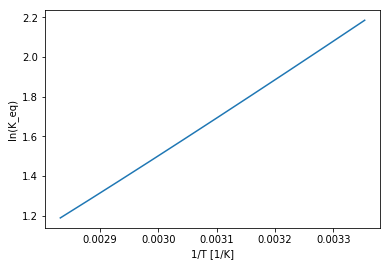

In [6]:
T_range = linspace(25+273.15, 80+273.15, 10)
ln_keq = []
for T in T_range:
    ln_keq.append(thermo.lnEquilibriumConstant(T, p, reac1).val)
plt.plot(1/T_range, ln_keq)
plt.xlabel("1/T [1/K]")
plt.ylabel("ln(K_eq)")
plt.show()

## Compare the results
We can calculate the enthalpy of reaction in different temperatures in Reaktoro and compare it with the approximate value that is the slope of the above line multiplied by -R. Let's do the calculation and plot the results:

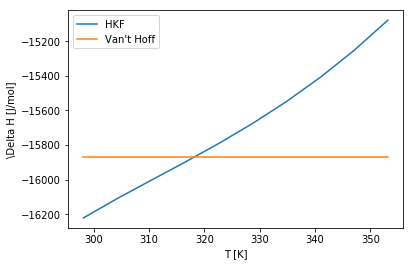

In [7]:
dh_fit  = -polyfit(1/T_range, ln_keq, 1)[0]*R
dh_calc = []
for T in T_range:
    dh_calc.append(thermo.standardPartialMolarEnthalpy(T, p, 'CaSO4(aq)').val+ \
    thermo.standardPartialMolarEnthalpy(T, p, 'OH-').val- \
    thermo.standardPartialMolarEnthalpy(T, p, 'SO4--').val- \
    thermo.standardPartialMolarEnthalpy(T, p, 'CaOH+').val)
plt.plot(T_range, dh_calc, label = "HKF")
plt.plot(T_range, ones(T_range.size)*dh_fit, label = "Van't Hoff")
plt.legend()
plt.xlabel("T [K]")
plt.ylabel("\Delta H [J/mol]")
plt.show()

In my opinion, it is very important for a software to enable the user to do the very basic stuff as Reaktoro helped me to do the above calculations. I still miss a few functionalities in Reaktoro: oxidation/reduction reaction and ion exchange/surface complexation models. Fortunately, Reaktoro is under active development and the new features will appear soon.